In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pickle as pkl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# 랜덤시드 설정

In [3]:
np.random.seed(1234) #initialize random seed to generate same random values every time

In [4]:
def load_data_from_pfile(file_path):  #Helper Function
    with open(file_path, 'rb') as pfile:
        sample_data = pkl.load(pfile)
    return sample_data

In [6]:
pkzfiles_path = '/content/drive/MyDrive/Colab Notebooks/noisy/test/'
pfiles = [pkzfiles_path+'bearing1_1_all_data.pkz', pkzfiles_path+'bearing1_2_all_data.pkz', \
          pkzfiles_path+'noisy_015_all_bearing1_1.pkz', pkzfiles_path+'noisy_015_all_bearing1_2.pkz', \
          pkzfiles_path+'noisy_025_all_bearing1_1.pkz', pkzfiles_path+'noisy_025_all_bearing1_2.pkz']

DATA = []
for pfile in pfiles:
    _data = load_data_from_pfile(pfile)
    _data['y'] = _data['y'][:, np.newaxis]
    DATA.append(_data)

In [8]:
class PHMDataset_Sequential(Dataset):

    def __init__(self, dataset_id=0, indices=[], seq_len=10):

        self.dataset_id = dataset_id
        self.indices = indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        sample_id = self.indices[i]
        sample = {'x': torch.from_numpy(DATA[self.dataset_id]['x'][sample_id:sample_id+self.seq_len]),
                  'y': torch.from_numpy(DATA[self.dataset_id]['y'][sample_id+self.seq_len-1])}
        return sample

**train 데이터와 validation 데이터셋으로 나눔( 9:1 비율 )**

In [9]:
SEQ_LEN = 10 # sequence length
VAL_SPLIT = 0.2

train_datasets, val_datasets = [], []
for dataset_id in range(len(DATA)):
    no_of_files = DATA[dataset_id]['x'].shape[0]
    no_of_seqs = no_of_files-SEQ_LEN+1
    no_of_val = int(VAL_SPLIT*no_of_seqs)
    perm = np.random.permutation(no_of_seqs)
    val_indices = perm[0:no_of_val]
    train_indices = perm[no_of_val:]

    train_dataset = PHMDataset_Sequential(dataset_id=dataset_id, indices=train_indices, seq_len=SEQ_LEN)
    val_dataset = PHMDataset_Sequential(dataset_id=dataset_id, indices=val_indices, seq_len=SEQ_LEN)
    print(len(train_dataset), len(val_dataset))

    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)

2236 558
690 172
2236 558
690 172
2236 558
690 172


#배치사이즈 설정

In [10]:
train_batch_size = 32
val_batch_size = 32

train, validation 데이터 모두 한번에 16개의 샘플을 로드할수있도록 설정

In [11]:
train_dataloaders = []
for train_dataset in train_datasets:
    train_dataloaders.append( DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1) )

val_dataloaders = []
for val_dataset in val_datasets:
    val_dataloaders.append( DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=1) )

# CNN_LSTM 모델 정의

In [12]:
def conv_bn_relu(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', batch_norm=True):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode)
    nn.init.xavier_uniform_(conv.weight)
    relu = nn.ReLU()
    if batch_norm:
        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels),
            relu
        )
    else:
        return nn.Sequential(
            conv,
            relu
        )

In [13]:
class CNN_CWT_Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv_bn_relu(2, 16, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = conv_bn_relu(16, 32, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = conv_bn_relu(32, 64, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.conv4 = conv_bn_relu(64, 128, 3, stride=1, padding=1, bias=True, batch_norm=True)
        self.pool4 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=0.2)

    def forward(self, x):
        # input shape = [Nx2x128x128]
        x = self.conv1(x) # [Nx16x128x128]
        x = self.pool1(x) # [Nx16x64x64]
        x = self.conv2(x) # [Nx32x64x64]
        x = self.pool2(x) # [Nx32x32x32]
        x = self.conv3(x) # [Nx64x32x32]
        x = self.pool3(x) # [Nx64x16x16]
        x = self.conv4(x) # [Nx128x16x16]
        x = self.pool4(x) # [Nx128x8x8]
        x = self.flatten(x) # [Nx8192] {128*8*8=8192} (N => batch size, 128 => no. of channels, 8*8 => height of image*width of image)
        x = self.fc1(x) # [Nx256]
        # x = self.dropout1(x) # apply dropout (Dropout is much harder to implement in LSTM)
        x = nn.ReLU()(x) # apply ReLU activation
        x = self.fc2(x) # [Nx128]
        x = nn.ReLU()(x) # apply ReLU activation
        return x

# 결함 예측을 위한 CNN_LSTM모델

In [14]:
class CNN_LSTM_FP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNN_CWT_Encoder()
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=256, num_layers=2, batch_first=True)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):

        batch_size, seq_len, C, H, W = x.size()
        x = x.view(batch_size*seq_len, C, H, W)
        x = self.encoder(x)
        x = x.view(batch_size, seq_len, -1)
        x, _ = self.lstm1(x)
        x = self.fc(x[:,-1,:])
        x = nn.Sigmoid()(x)
        return x

cpu에서 gpu로 프로세스 할당

In [15]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device

cuda:0


device(type='cuda', index=0)

**모델 연결**

In [16]:
'''
connecting CNN_LSTM_FP() model (or CNN_LSTM_FP() class) to the device(here device is the GPU). (Note: model.to(device) connects the model or moves the model to
the device(i.e. either CPU or GPU) so that we can perform our model training on the device(CPU or GPU))
'''
model = CNN_LSTM_FP().to(device)

MSE손실함수값을 합산하여 반환

In [17]:
criterion = nn.MSELoss(reduction='sum')

옵티마이저 설정

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)

학습률 조정(지정 에폭마다 학습률을 감소)

In [19]:
multistep_lr_sch = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30], gamma=0.1, last_epoch=-1, verbose=False)

에폭 설정

In [20]:
def train_epoch(model, dataloader, criterion, optimizer):
    total_loss = 0
    num_of_samples = 0
    model.train()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        optimizer.zero_grad()
        y_prediction = model(x)
        loss = criterion(y_prediction, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

In [21]:
def eval(model, dataloader, criterion):
    total_loss = 0
    num_of_samples = 0
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y'].to(device, dtype=torch.float)

        with torch.no_grad():
            y_prediction = model(x)
            loss = criterion(y_prediction, y)

        total_loss += loss.cpu().item()
        num_of_samples += x.shape[0]
    return total_loss/num_of_samples

훈련

In [22]:
# Define a directory to save the best model and results
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

# Initialize variables to keep track of the best model and its validation loss
best_val_loss = float('inf')
best_model = None

max_epochs = 30
loss_vals = []  # Placeholder to store history of loss values for each epoch

for epoch in range(max_epochs):
    train_loss = 0
    for train_dataloader in train_dataloaders:
        train_loss += train_epoch(model, train_dataloader, criterion, optimizer)
    train_loss /= len(train_dataloaders)

    val_loss = 0
    for val_dataloader in val_dataloaders:
        val_loss += eval(model, val_dataloader, criterion)
    val_loss /= len(val_dataloaders)

    # multistep_lr_sch.step()
    loss_vals.append([train_loss, val_loss])
    print('{0}/{1}: train_loss = {2:.4f}, val_loss = {3:.4f}'.format(epoch+1, max_epochs, train_loss, val_loss) )

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        # Save the best model's state_dict to a file
        best_model_filename = os.path.join(save_dir, 'best_model.pth')
        torch.save(best_model, best_model_filename)
        print('Best model saved with validation loss: {:.4f}'.format(best_val_loss))

# Save the loss values history to a file
loss_vals_filename = os.path.join(save_dir, 'loss_values.pth')
torch.save(loss_vals, loss_vals_filename)
print('Loss values history saved.')

1/30: train_loss = 0.0463, val_loss = 0.0487
Best model saved with validation loss: 0.0487
2/30: train_loss = 0.0211, val_loss = 0.0260
Best model saved with validation loss: 0.0260
3/30: train_loss = 0.0135, val_loss = 0.0348
4/30: train_loss = 0.0099, val_loss = 0.0169
Best model saved with validation loss: 0.0169
5/30: train_loss = 0.0102, val_loss = 0.0142
Best model saved with validation loss: 0.0142
6/30: train_loss = 0.0077, val_loss = 0.0205
7/30: train_loss = 0.0070, val_loss = 0.0124
Best model saved with validation loss: 0.0124
8/30: train_loss = 0.0078, val_loss = 0.0069
Best model saved with validation loss: 0.0069
9/30: train_loss = 0.0060, val_loss = 0.0048
Best model saved with validation loss: 0.0048
10/30: train_loss = 0.0044, val_loss = 0.0060
11/30: train_loss = 0.0046, val_loss = 0.0098
12/30: train_loss = 0.0053, val_loss = 0.0047
Best model saved with validation loss: 0.0047
13/30: train_loss = 0.0029, val_loss = 0.0038
Best model saved with validation loss: 0.00

학습률의 loss값을 시각화

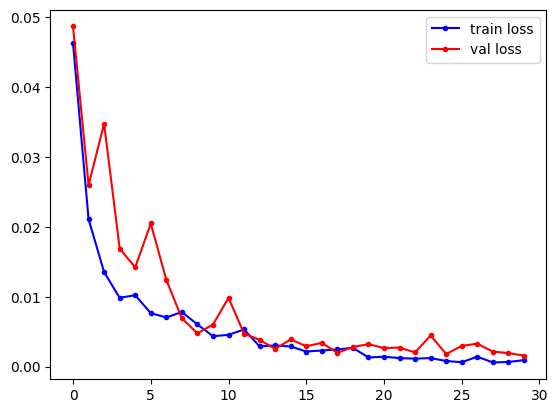

In [23]:
plt.plot(range(len(loss_vals)), [l[0] for l in loss_vals], 'b.-', label='train loss')
plt.plot(range(len(loss_vals)), [l[1] for l in loss_vals], 'r.-', label='val loss')
plt.legend()
plt.show()

**모델 불러오기**

In [ ]:
model.load_state_dict(torch.load('/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/model/CNN-LSTM/inout/cnn_lstm_model3.pth'))

<All keys matched successfully>

인퍼런스 적용

In [ ]:
def model_inference_helper(model, dataloader):
    results = {'labels':[], 'predictions':[]}
    model.eval()
    for i, batch in enumerate(dataloader):
        x = batch['x'].to(device, dtype=torch.float)
        y = batch['y']

        with torch.no_grad():
            y_prediction = model(x)

        if y.size(0)>1:
            results['labels'] += y.squeeze().tolist()
            results['predictions'] += y_prediction.cpu().squeeze().tolist()
        elif y.size(0)==1:
            results['labels'].append(y.squeeze().tolist())
            results['predictions'].append(y_prediction.cpu().squeeze().tolist())
    return results

데이터 정렬

In [ ]:
def sort_results(results):
    ind = [i[0] for i in sorted(enumerate(results['labels']), key=lambda x: x[1])]
    results['labels'] = [results['labels'][i] for i in ind]
    results['predictions'] = [results['predictions'][i] for i in ind]
    return results

**bearing1_1.pkz dataset에 대한 예측결과**

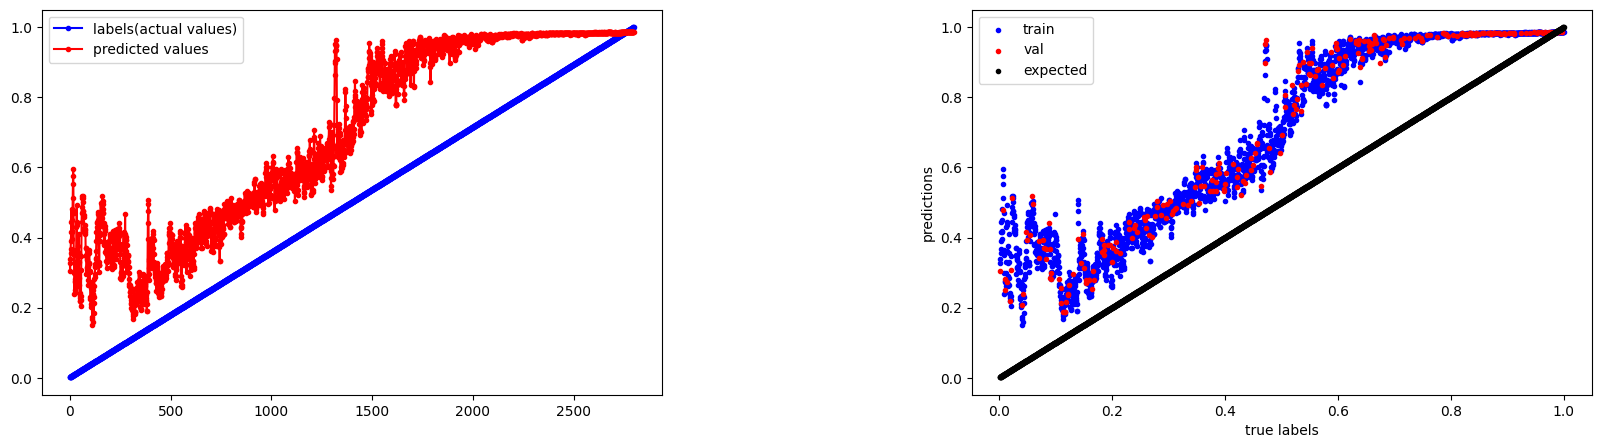

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[0])
val_results = model_inference_helper(model, val_dataloaders[0])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
train_dataloaders[0]

**bearing1_2.pkz dataset에 대한 예측결과**

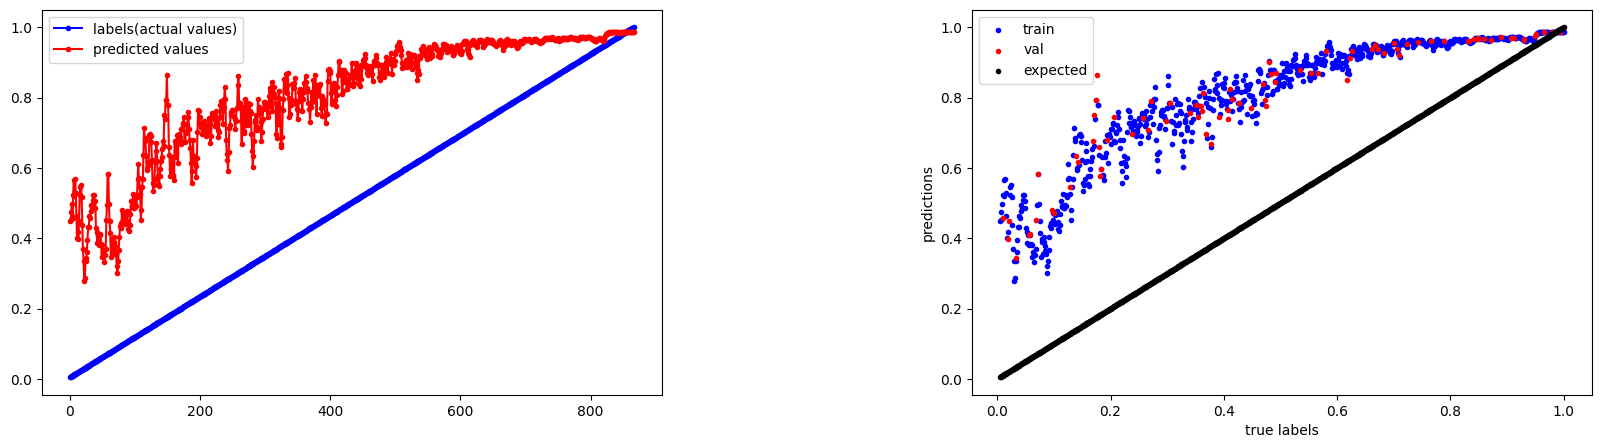

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[1])
val_results = model_inference_helper(model, val_dataloaders[1])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

**bearing2_1.pkz dataset에 대한 예측결과**

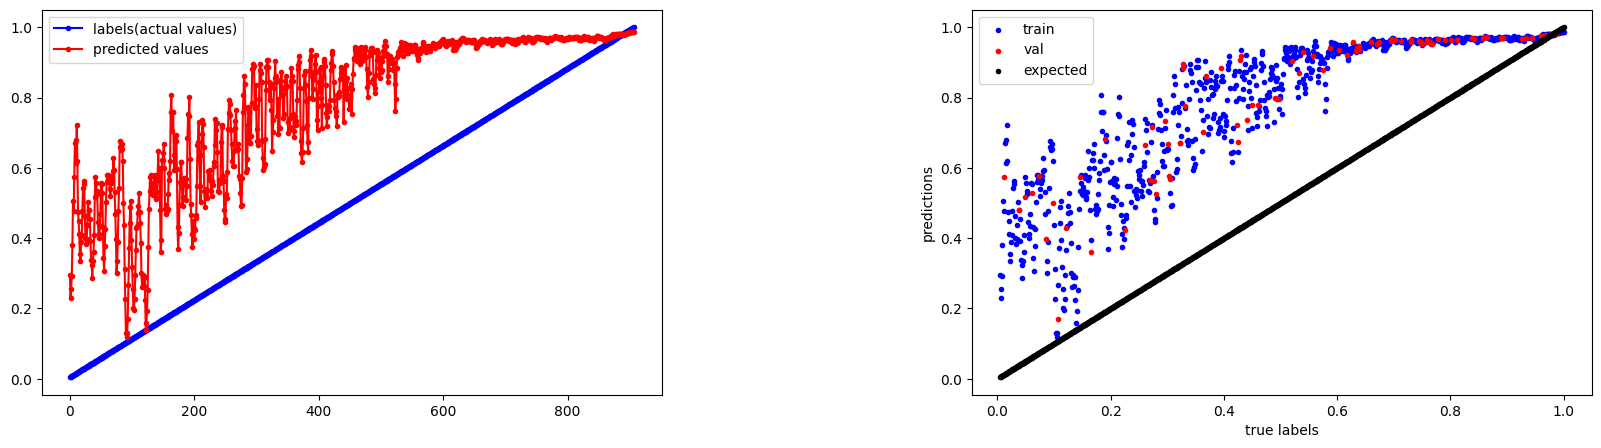

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[2])
val_results = model_inference_helper(model, val_dataloaders[2])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

**bearing2_2.pkz dataset에 대한 예측결과**

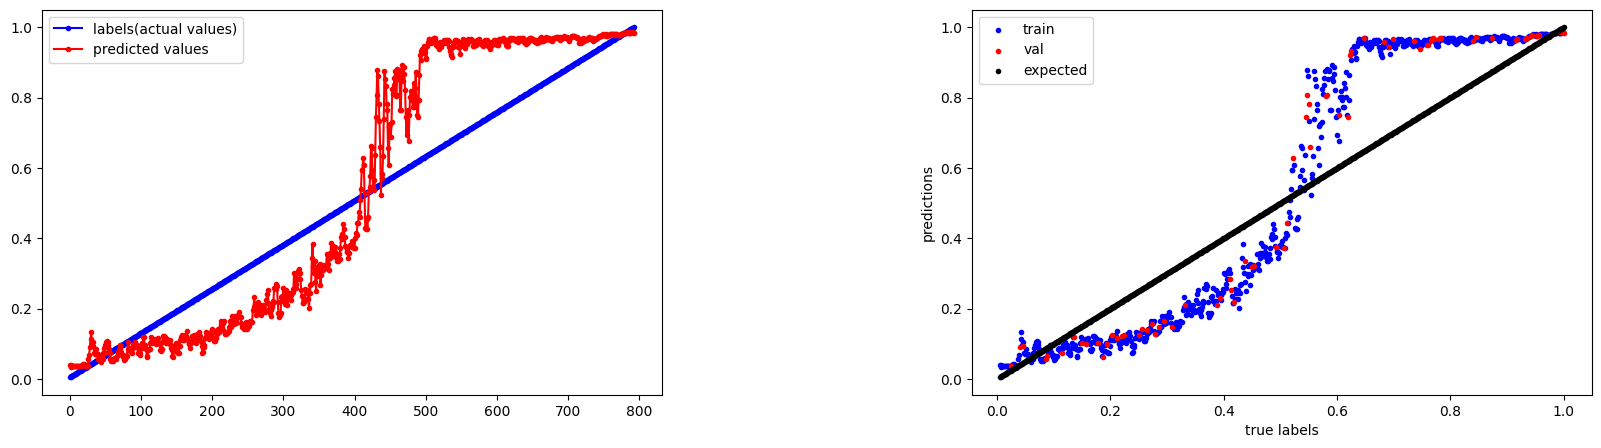

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[3])
val_results = model_inference_helper(model, val_dataloaders[3])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

**bearing3_1.pkz dataset에 대한 예측결과**

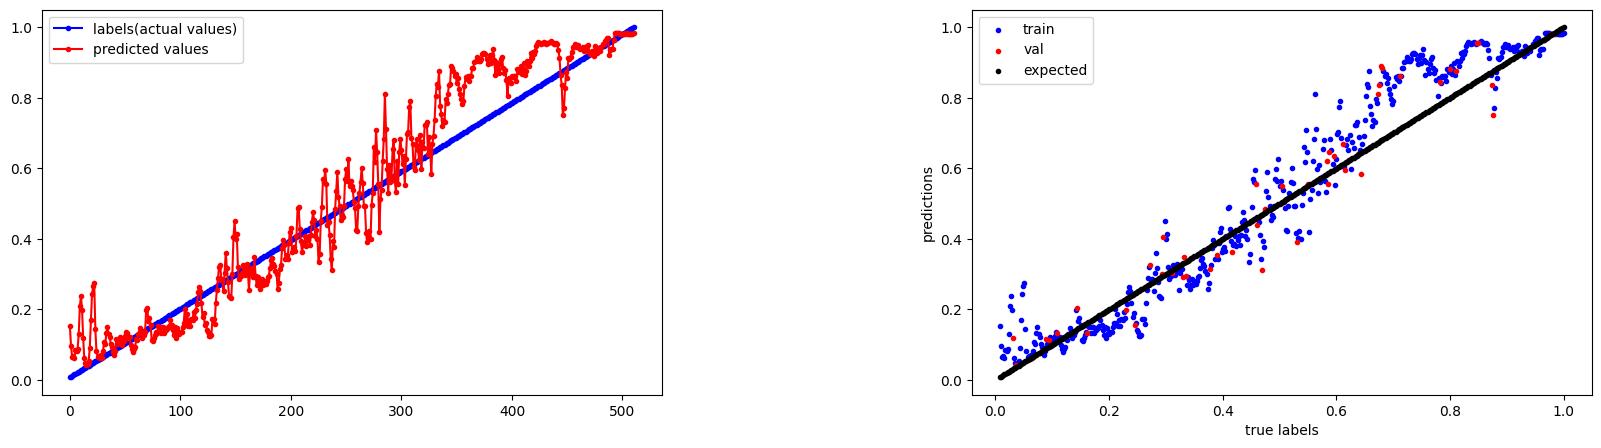

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[4])
val_results = model_inference_helper(model, val_dataloaders[4])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

**bearing3_2.pkz dataset에 대한 예측결과**

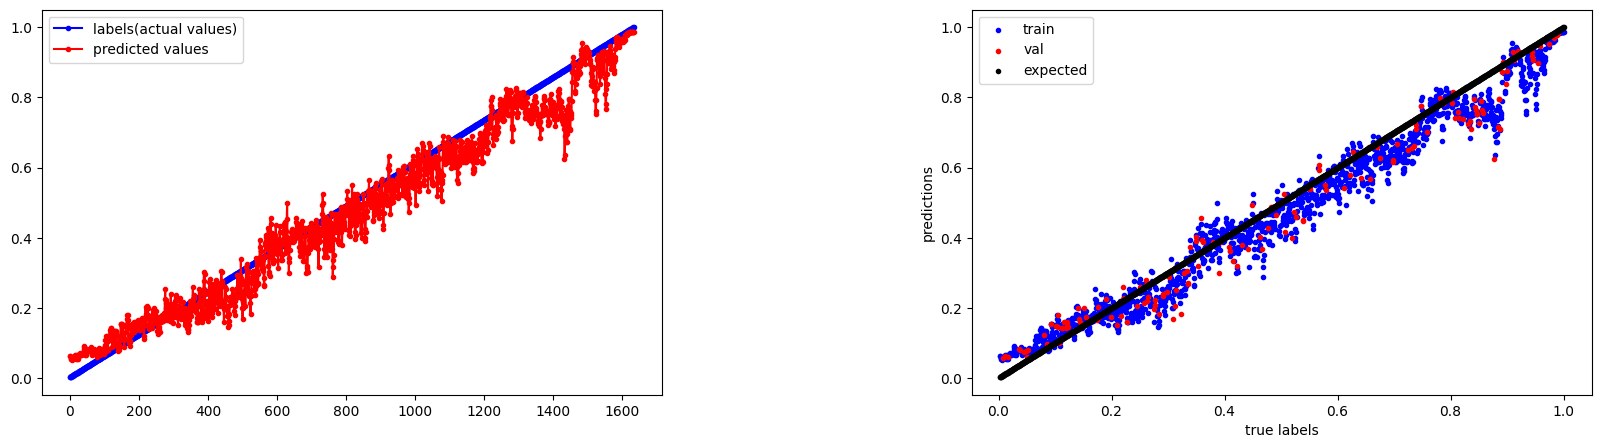

In [ ]:
train_results = model_inference_helper(model, train_dataloaders[5])
val_results = model_inference_helper(model, val_dataloaders[5])
results = {'labels': train_results['labels']+val_results['labels'], 'predictions': train_results['predictions']+val_results['predictions']}
results = sort_results(results)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[20,5])
ax[0].plot(range(len(results['labels'])), results['labels'], 'b.-', label='labels(actual values)')
ax[0].plot(range(len(results['predictions'])), results['predictions'], 'r.-', label='predicted values')
ax[0].legend()
ax[1].scatter(train_results['labels'], train_results['predictions'], marker='.', c='b', label='train')
ax[1].scatter(val_results['labels'], val_results['predictions'], marker='.', c='r', label='val')
ax[1].scatter(results['labels'], results['labels'], marker='.', c='k', label='expected')
ax[1].set_xlabel('true labels')
ax[1].set_ylabel('predictions')
ax[1].legend()
plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
model2 = model